# Packages

In [1]:
import os
import os.path as op
import sys
 
import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import scipy
import scipy.ndimage
from scipy.stats import linregress
import healpy as hp
import jdcal as jdcal
import random                                                                                               
import time

from multiprocessing import Pool
from getdist import plots, MCSamples
import getdist
import time

from qubic import fibtools as ft

%matplotlib inline

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


# Useful functions

In [2]:
def corr_function(r, r0):
    if r==0:
        return 1
    return 2**(2/3) * (r/r0)**(1/3) * scipy.special.kv(1/3, r/r0) / scipy.special.gamma(1/3)

In [3]:
def f_to_k(f):
    return 2*scipy.constants.pi*f / scipy.constants.c

In [4]:
def water_vapor_density(z, rho_0, h0):
    return rho_0 * np.exp(-np.log(2) * (z - 5190) / h0)

# Simulation Parameters

In [5]:
# Parameters
N = 200                   # Grid size
maximum_length = 300 # Correlation length for water vapor density (m)
h = 4869                  # Height for QUBIC + 1km (m)
h0 = 983                  # Reference height (m)
rho_0 = 0.55              # Median density of water vapor at h0 (g/m3)
L = 5000                  # Atm size (m)
Lz = 1000                 # Atm depth (m)
L_QUBIC = h * np.sin(np.radians(15))    

# Calculate water vapor density
water_vapor_0 = water_vapor_density(h, rho_0, h0)

# Generate meshgrid
x = np.linspace(-L, L, N)
y = np.linspace(-L, L, N)
X, Y = np.meshgrid(x, y)

dx, dy = int(2 * L / N), int(2 * L / N)


# Correlation matrix

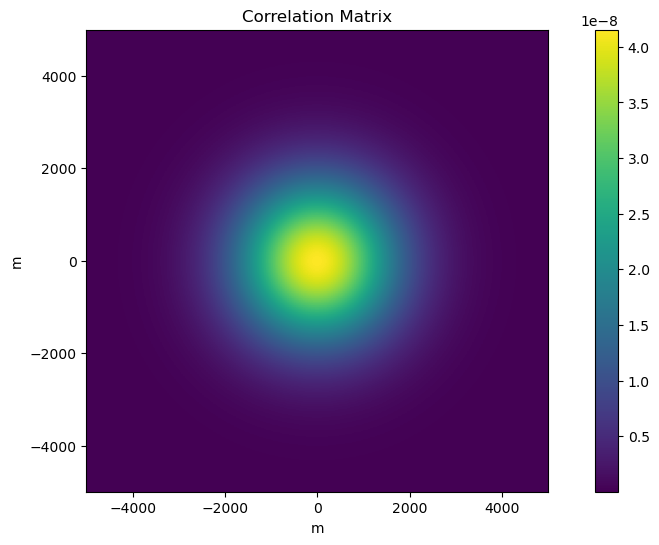

In [6]:
# Calculate distance from detector
R = np.sqrt((X)**2 + (Y)**2 + h**2)

# Calculate correlation function
corr = np.zeros((len(R), len(R)))
for i in range(len(R)):
    for j in range(len(R)):
        corr[i][j] = corr_function(R[i][j], maximum_length)

# Plot correlation matrix around a central point
plt.figure(figsize=(12, 6))
plt.imshow(corr, extent=[-L, L, -L, L], origin='lower')
plt.colorbar()
plt.xlabel('m')
plt.ylabel('m')
plt.title('Correlation Matrix')
plt.show()

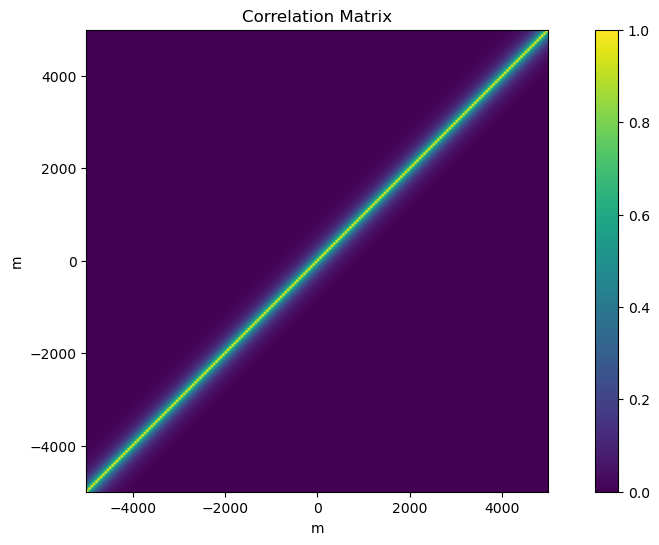

In [7]:
# Calculate distances between all points on the grid
distances = np.sqrt((X-X.T)**2 + (Y-Y.T)**2)

# Calculate correlation function
correlation_matrix = np.zeros((len(R), len(R)))
for i in range(len(R)):
    for j in range(len(R)):
        correlation_matrix[i][j] = corr_function(distances[i][j], maximum_length)

# Plot correlation matrix with distances
plt.figure(figsize=(12, 6))
plt.imshow(correlation_matrix, extent=[-L, L, -L, L], origin='lower')
plt.colorbar()
plt.xlabel('m')
plt.ylabel('m')
plt.title('Correlation Matrix')
plt.show()

In [8]:
# Trial to simulate a random water vapor distribution using the cholesky decomposition of the correlation matrix
# It doesn't work for know, need to think about it

#cholesky_decomposition = np.linalg.cholesky(correlation_matrix)
#uncorrelated_samples = np.random.randn(N, N)
#correlated_samples = water_vapor_0 + np.dot(cholesky_decomposition, uncorrelated_samples)

#plt.imshow(correlated_samples, extent=[-L, L, -L, L], cmap='jet')
#plt.colorbar(label='Water vapor density')
#plt.title('Water Vapor Spatial Fluctuations')
#plt.xlabel('X')
#plt.ylabel('Y')
#plt.show()

# Water vapor density fluctuations

## 2D Simulation

In [9]:
# Generate spatial frequency in Fourier space
k_distrib = np.fft.fftfreq(N, d=2*L/N) * 2*np.pi
kx, ky = np.meshgrid(k_distrib, k_distrib)
k_mag = np.sqrt(kx**2 + ky**2)

In [10]:
# We will use the Kolomogorov power spectrum to simulate turbulences in atmosphere
def kolmogorov_spectra(k):
    return (maximum_length**(-2) + np.abs(k)**2)**(-11/6)

# We normalize to have the integral of the power spectrum over all k egal to 1
def normalized_kolmogorov(k): 
    res, _ = scipy.integrate.quad(kolmogorov_spectra, np.min(k_mag), np.max(k_mag)) 
    return kolmogorov_spectra(k)/res

print(scipy.integrate.quad(normalized_kolmogorov, np.min(k_mag), np.max(k_mag))[0])

1.0


In [11]:
k = np.sqrt(2*k_distrib**2)
kol = np.abs(k)**(-11/3)
kol_adj = (50**(-2) + np.abs(k)**2)**(-11/6)

/tmp/ipykernel_17333/2434994118.py:2: RuntimeWarning: divide by zero encountered in power
  kol = np.abs(k)**(-11/3)


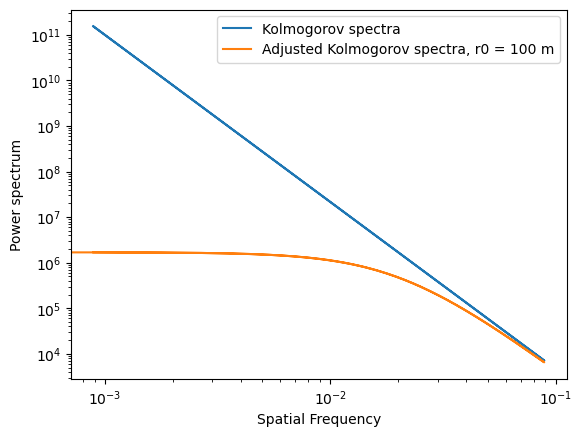

In [12]:
plt.plot(k, kol, label = 'Kolmogorov spectra')
plt.plot(k, kol_adj, label = 'Adjusted Kolmogorov spectra, r0 = 100 m')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power spectrum')
plt.legend()
plt.show()

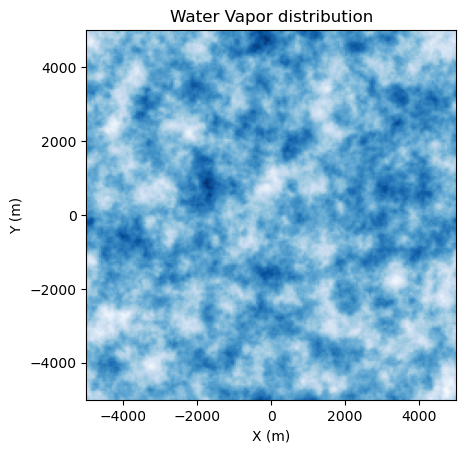

In [13]:
# Compute the Kolmogorov power spectrum 
P_k = normalized_kolmogorov(k_mag)

# Generate spatial fluctuations using the spatial power spectrum
phi = np.random.uniform(0, 2*np.pi, size=(N, N))
delta_rho_k = np.sqrt(P_k) * np.exp(1j * phi) # PS = fluctuations amplitude

# Apply inverse Fourier transform to obtain spatial fluctuations
delta_rho = np.fft.ifft2(delta_rho_k).real
rho = water_vapor_0 + delta_rho - np.mean(delta_rho)

# Plot the water vapor density distribution
plt.imshow(rho, extent=[-L, L, -L, L], cmap='Blues')
#plt.colorbar(label='Water Vapor density (g/m3)')
plt.title('Water Vapor distribution')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.show()

## Verification

/home/laclavere/miniconda3/envs/venv-qubic/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laclavere/miniconda3/envs/venv-qubic/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/laclavere/miniconda3/envs/venv-qubic/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/laclavere/miniconda3/envs/venv-qubic/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/laclavere/miniconda3/envs/venv-qubic/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


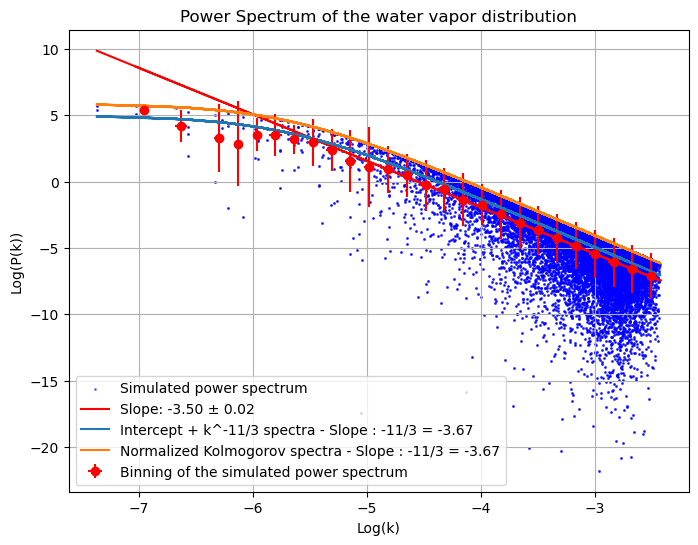

Slope of the power spectrum: -3.50


In [14]:
# Compute the 2D FT of the distribution 
fft_rho = np.fft.fft2(rho)

# Compute the power spectrum of the distribution
power_spectrum = np.abs(fft_rho)**2

# Flatten the power spectrum and spatial frequency arrays
power_spectrum_flat = power_spectrum.ravel()
k_flat = k_mag.ravel()
kolmogorov = kolmogorov_spectra(k_mag).ravel()
norm_kolmogorov = normalized_kolmogorov(k_flat)

# Remove zero frequency component
power_spectrum_flat = power_spectrum_flat[1:]
k_flat = k_flat[1:]
kolmogorov = kolmogorov[1:]
norm_kolmogorov = norm_kolmogorov[1:]

# Compute the logarithm of the power spectrum
log_power_spectrum = np.log(power_spectrum_flat)

# Fit a line to the logarithm of the power spectrum
res = linregress(np.log(k_flat), log_power_spectrum)
slope, intercept, std_err = res.slope, res.intercept, res.stderr

# Create bins for the power spectrum. Allows to understand the fitted line
xx, yy, dx, dy, _ = ft.profile(np.log(k_flat), log_power_spectrum, rng=[min(np.log(k_flat)),max(np.log(k_flat))], nbins=30, plot=False)

# Plot the power spectrum and the fit
plt.figure(figsize=(8, 6))
plt.scatter(np.log(k_flat), log_power_spectrum, s=1, color='blue', alpha = 0.5, label='Simulated power spectrum')
plt.errorbar(xx, yy, xerr=dx, yerr=dy, fmt='ro', label='Binning of the simulated power spectrum')
plt.plot(np.log(k_flat), slope * np.log(k_flat) + intercept, color='red', label=f'Slope: {slope:.2f} ' + "\u00B1" + f' {std_err:.2f}')
plt.plot(np.log(k_flat), np.log(kolmogorov) + intercept, label=f'Intercept + k^-11/3 spectra - Slope : -11/3 = {-11/3:.2f}')
plt.plot(np.log(k_flat), np.log(norm_kolmogorov), label=f'Normalized Kolmogorov spectra - Slope : -11/3 = {-11/3:.2f}')
plt.xlabel('Log(k)')
plt.ylabel('Log(P(k))')
plt.title('Power Spectrum of the water vapor distribution')
plt.legend()
plt.grid(True)
plt.show()

print(f"Slope of the power spectrum: {slope:.2f}")

# Tests for 3D simulation

## Naive model

In [15]:
# Générer les fréquences spatiales
k_distrib = np.fft.fftfreq(N, d=2*L/N) * 2*np.pi
kx, ky, kz = np.meshgrid(k_distrib, k_distrib, k_distrib)
k_mag_3d = np.sqrt(kx**2 + ky**2 + kz**2)

# Calculer le spectre de puissance spatial de Kolmogorov
P_k_3d = normalized_kolmogorov(k_mag_3d)

# Générer les fluctuations spatiales en utilisant le spectre de puissance spatial
phi_3d = np.random.uniform(0, 2*np.pi, size=(N, N, N))
delta_rho_k_3d = np.sqrt(P_k_3d) * np.exp(1j * phi_3d) # PS = fluctuations amplitude

# Appliquer la transformation de Fourier inverse pour obtenir les fluctuations spatiales
delta_rho_3d = np.fft.ifftn(delta_rho_k_3d).real

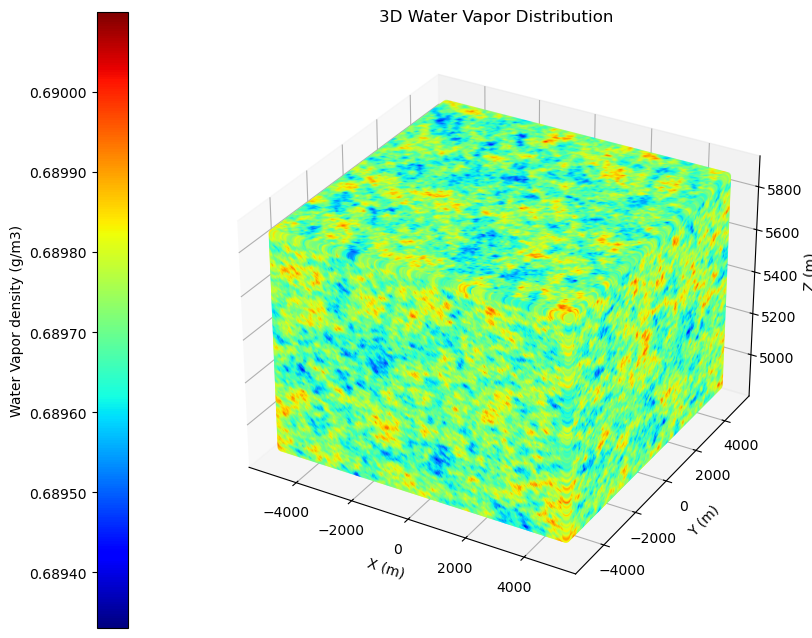

In [16]:
rho_3d = np.zeros((N, N, N))
rho_3d = water_vapor_0 + delta_rho_3d - np.mean(delta_rho_3d)

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
z = np.linspace(h, h+Lz, N)
dz = int(Lz / N)
X, Y, Z = np.meshgrid(x, y, z)

scatter = ax.scatter(X, Y, Z, c=rho_3d, cmap='jet')

# Set labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Water Vapor Distribution')
cbar = fig.colorbar(scatter, ax=ax, format = '%.5f', location='left')
cbar.set_label('Water Vapor density (g/m3)')
plt.show()

## Realistic 3D simulation

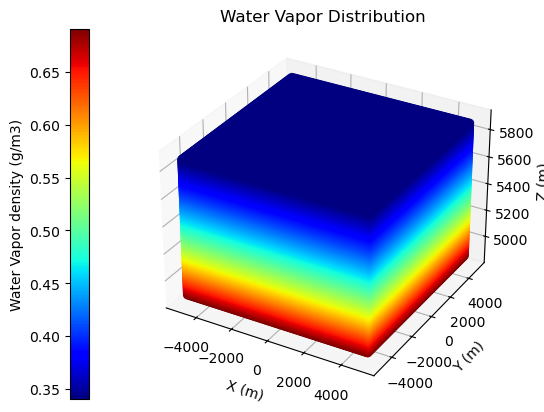

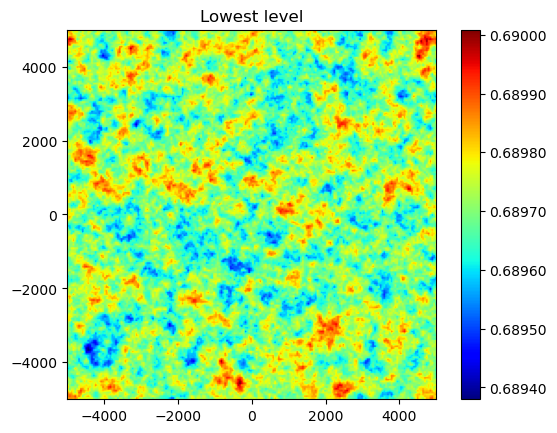

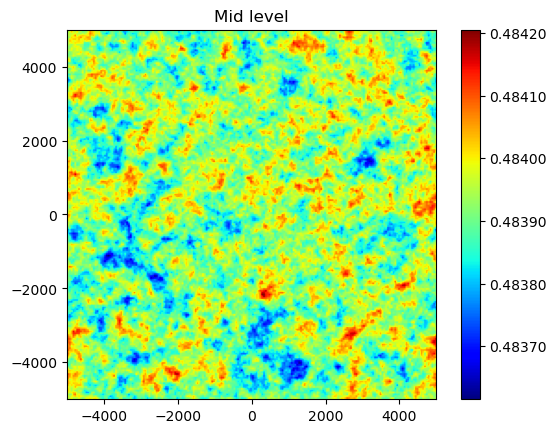

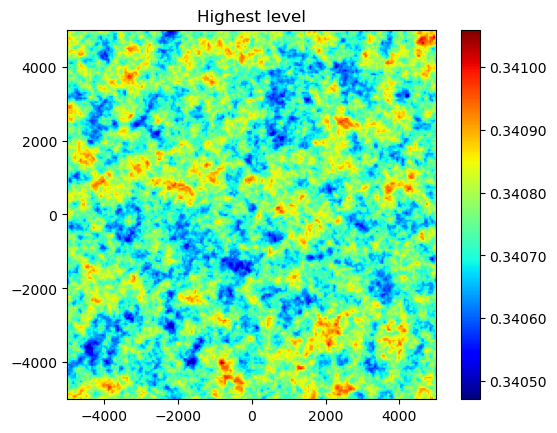

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

water_vapor_real = water_vapor_density(z, rho_0, h0)
rho_3d_real = np.zeros((N, N, N))
for i in range(N):
    rho_3d_real[:, :, i] = water_vapor_real[i] + delta_rho_3d[:, :, i] - np.mean(delta_rho_3d[:,:,i])

scatter_real = ax.scatter(X, Y, Z, c=rho_3d_real, cmap='jet')

# Set labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Water Vapor Distribution')
cbar = fig.colorbar(scatter_real, ax=ax, location = 'left')
cbar.set_label('Water Vapor density (g/m3)')
plt.show()

plt.figure()
plt.imshow(rho_3d_real[:, :, 0], extent=[-L, L, -L, L], cmap='jet')
plt.title('Lowest level')
plt.colorbar(format = '%.5f')
plt.show()

plt.figure()
plt.imshow(rho_3d_real[:, :, int(N/2)], extent=[-L, L, -L, L], cmap='jet')
plt.title('Mid level')
plt.colorbar(format = '%.5f')
plt.show()

plt.figure()
plt.imshow(rho_3d_real[:, :, -1], extent=[-L, L, -L, L], cmap='jet')
plt.title('Highest level')
plt.colorbar(format = '%.5f')
plt.show()

# Wind simulation

## Functions used to simulate wind

In [18]:
# Functions to make a translation of the 2d atmosphere

def x_translation(array, dx):
    shape = np.shape(array)
    copy = np.zeros(shape)
    for x in range(shape[0]):
        if x+dx >= N:
            copy[x + dx - shape[0]] = array[x]
        else:
            copy[x+dx] = array[x]
    return copy
def y_translation(array, dy):
    shape = np.shape(array)
    copy = np.zeros(shape)
    for y in range(shape[1]):
        if y+dy >= N:
            copy[:,y + dy - shape[1]] = array[:,y]
        else:
            copy[:,y+dy] = array[:,y]
    return copy
def z_translation(array, dz):
    shape = np.shape(array)
    copy = np.zeros(shape)
    for z in range(shape[2]):
        if z+dz >= N:
            copy[:,:,z + dz - shape[2]] = array[:,:,z]
        else:
            copy[:,:,z+dz] = array[:,:,z]
    return copy
def translation(array, dx, dy):
    array = x_translation(array, dx)
    return y_translation(array, dy)
def translation_3d(array, dx, dy, dz):
    array = x_translation(array, dx)
    array = y_translation(array, dy)
    return z_translation(array, dz)

## Constant wind

In [19]:
# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(rho, extent=[-L, L, -L, L], cmap='jet')
fig.colorbar(mappable = im, ax=ax, label='Water Vapor density (g/m3)', format = '%.5f')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Water vapor distribution with wind')

# Animation parameters
time = 50
dt = 0.1
Nt = int(time/dt)
dux, duy = 1, 2

# Animation function
def update(frame):
    global rho
    if frame > 0:
        rho = translation(rho, dux, duy)
    im.set_array(rho)
    return [im]

# Create animation
ani = matplotlib.animation.FuncAnimation(fig, update, frames=Nt+1, interval=100, blit=True)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

# Display the animation
display(display_animation(ani))

## Alto Chorrillos wind data

In [ ]:
ts0, rec0, WS_ms_Avg, WS_ms_Std, WS_ms_Max, WS_ms_S_WVT, WindDir_D1_WVT, WindDir_SD1_WVT = np.loadtxt('chorrillo-t1m_cal.csv', usecols = [2,3,4,5,6,7,8,9]).T
### ts0 is in seconds sampled every minute

### Conversion in Julian days
init = np.sum(jdcal.gcal2jd(1970,1,1))
jd0 = ts0/3600/24
jdcal.jd2gcal(init, jd0[0])
jdcal.jd2gcal(init, jd0[-1])
jdstartyear = np.sum(jdcal.gcal2jd(2011,1,1))
jdsince0 = init + ts0/3600/24 - jdstartyear

plt.plot(jdsince0, WS_ms_Max, 'r.', label='Max speed within 1 minute')
plt.plot(jdsince0, WS_ms_Avg, label='Average speed within 1 minute')
plt.plot(jdsince0, WS_ms_Std, label='RMS speed within 1 minute')
plt.xlabel('JD since 2011')
plt.ylabel('Wind Speed $[m/s]$')
plt.legend()
    
def statstr(vec):
    m=np.mean(vec)
    s=np.std(vec)
    return '{0:.4f} +/- {1:.4f}'.format(m,s)

def statstr2(thedata, percentiles=[0.25, 0.5, 0.75]):
    sd = np.sort(thedata)
    truc = ''
    vals = []
    for perc in percentiles:
        vals.append(sd[(int)(perc*len(sd))])
        truc = truc + '{0:.1f} ({1:.0f}%) - '.format(sd[(int)(perc*len(sd))], perc*100)
    return truc[0:-3], vals

In [ ]:
print(1100*24*60, len(WS_ms_Avg))

## Average, RMS & max velocities histograms

In [ ]:
plt.figure(figsize=(15, 6))

# Average wind speed plot
plt.subplot(1, 3, 1)
wind_speed_avg = plt.hist(WS_ms_Avg, range=[0, np.max(WS_ms_Avg)], bins=300, cumulative=True, density=True, alpha=0, stacked=True)
hist_wind_speed_avg = plt.hist(WS_ms_Avg, range=[0,np.max(WS_ms_Avg)], bins=30, density=True, stacked=True, color='red')
plt.plot(wind_speed_avg[1][0:-1], wind_speed_avg[0]*np.max(hist_wind_speed_avg[0]),'k', lw=3, label = statstr2(WS_ms_Avg)[0])
plt.legend()
plt.xlim(0,np.max(WS_ms_Avg))
plt.grid()
plt.xlabel('Wind Speed [m/s]')
plt.title('Average over 1 minute')
plt.ylim(0,np.max(hist_wind_speed_avg[0])*1.1)

# RMS wind speed plot
plt.subplot(1,3,2)
wind_speed_rms=plt.hist(WS_ms_Std, range=[0,np.max(WS_ms_Std)], bins=300, cumulative=True,density=True, alpha=0., stacked=True)
hist_wind_speed_rms = plt.hist(WS_ms_Std, range=[0,np.max(WS_ms_Std)], bins=30, density=True, stacked=True, color='red')
plt.plot(wind_speed_rms[1][0:-1], wind_speed_rms[0]*np.max(hist_wind_speed_rms[0]),'k', lw=3, label = statstr2(WS_ms_Std)[0])
plt.legend()
plt.xlim(0,np.max(WS_ms_Std))
plt.grid()
plt.xlabel('Wind Speed [m/s]')
plt.title('RMS over 1 minute')
plt.ylim(0,np.max(hist_wind_speed_rms[0])*1.1)

# Max wind speed plot
plt.subplot(1,3,3)
wind_speed_max=plt.hist(WS_ms_Max, range=[0,np.max(WS_ms_Max)], bins=300, cumulative=True,density=True, alpha=0., stacked=True)
hist_wind_speed_max = plt.hist(WS_ms_Max, range=[0,np.max(WS_ms_Max)], bins=30, density=True, stacked=True, color='red')
plt.plot(wind_speed_max[1][0:-1], wind_speed_max[0]*np.max(hist_wind_speed_max[0]),'k', lw=3, label = statstr2(WS_ms_Max)[0])
plt.legend()
plt.xlim(0,np.max(WS_ms_Max))
plt.grid()
plt.xlabel('Wind Speed [m/s]')
plt.title('Max over 1 minute')
plt.ylim(0,np.max(hist_wind_speed_max[0])*1.1)
plt.show()

## Wind direction & amplitude 2D histogram

In [ ]:
wind_x = WS_ms_Avg * np.cos(-np.pi/2-np.radians(WindDir_D1_WVT))
wind_y = WS_ms_Avg * np.sin(-np.pi/2-np.radians(WindDir_D1_WVT))
mask = (wind_x==0) & (wind_y==0)

speed_limit_x, speed_limit_y = 20, 20 # m/s
hist2d_wind, _, _, _ = plt.hist2d(wind_x[~mask],wind_y[~mask], bins=300, range=[[-speed_limit_x,speed_limit_x],[-speed_limit_y,speed_limit_y]],density=True)
hist2d_wind_filtered = scipy.ndimage.gaussian_filter(hist2d_wind, 1.5)

plt.clf()
plt.imshow(hist2d_wind_filtered.T, origin='lower',cmap='jet', extent=[-speed_limit_x,speed_limit_x,-speed_limit_x,speed_limit_x])
plt.xlabel('E/W (m/s)')
plt.ylabel('N/S (m/s)')
plt.colorbar()
plt.title('Wind direction and amplitude histogram')

## 2D Power Spectrum : unused

In [ ]:
# Compute the 2d power spectrum of the wind
fft_wind = np.fft.fft2(hist2d_wind_filtered.T)
power_spectrum_wind = np.abs(fft_wind)**2

plt.plot(power_spectrum_wind)
plt.title('Wind power spectrum at Alto Chorillos')
plt.xscale('log')
plt.yscale('log')

## Wind velocity distribution along East/West & North/South axis

In [ ]:
plt.figure()
hist_y = plt.hist(wind_y[~mask], bins=300, density=True, label='N/S', alpha=0.8)
hist_x = plt.hist(wind_x[~mask], bins=300, density=True, label='E/W', alpha=0.8)
plt.xlabel('Wind speed m/s')
plt.title('Wind velocity histogram')
plt.legend()

## Power Spectra along E/W & N/S axis

In [ ]:
fft_x = np.fft.fft(wind_x[~mask])
fft_y = np.fft.fft(wind_y[~mask])

power_spectrum_x = np.abs(fft_x)**2
power_spectrum_y = np.abs(fft_y)**2

ff = np.fft.fftfreq(len(fft_x), d=60)

plt.plot(ff, power_spectrum_x, label='E/W')
plt.plot(ff, power_spectrum_y, label='N/S')
plt.plot(ff, np.abs(fft_x*np.conjugate(fft_y)), label='Cross')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Wind Power Spectra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')

## Random wind distriubtions along E/W & N/S axis

In [ ]:
# Generate random phases
random_phases_x = np.exp(1j * np.random.uniform(0, 2*np.pi, size=len(power_spectrum_x)))
random_phases_y = np.exp(1j * np.random.uniform(0, 2*np.pi, size=len(power_spectrum_y)))

# Perform Inverse Fourier Transform to obtain the random wind field
random_wind_x = np.fft.ifft(np.sqrt(power_spectrum_x) * random_phases_x).real
random_wind_y = np.fft.ifft(np.sqrt(power_spectrum_y) * random_phases_y).real
print(np.mean(random_wind_x) - np.mean(wind_x), np.mean(random_wind_y) - np.mean(wind_y))
random_wind_x = random_wind_x - np.mean(random_wind_x) + np.mean(wind_x)
random_wind_y = random_wind_y - np.mean(random_wind_y) + np.mean(wind_y)

plt.figure()
random_hist_x = plt.hist(random_wind_x, bins=300, density=True, label='E/W')
random_hist_y = plt.hist(random_wind_y, bins=300, density=True, label='N/S')
plt.xlabel('Wind speed m/s')
plt.title('Random wind velocity histogram')
plt.legend()

In [ ]:
plt.figure()
speed_limit_x, speed_limit_y = 20, 20 # m/s
random_hist2d_wind, _, _, _ = plt.hist2d(random_wind_x,random_wind_y, bins=300,range=[[-speed_limit_x,speed_limit_x],[-speed_limit_y,speed_limit_y]],density=False)
random_hist2d_wind_filtered = scipy.ndimage.gaussian_filter(random_hist2d_wind, 1.5)
plt.xlabel('E/W (m/s)')
plt.ylabel('N/S (m/s)')
plt.colorbar()
plt.title('Random Wind direction and amplitude histogram')

plt.figure()
plt.imshow(random_hist2d_wind_filtered.T, origin='lower', cmap='jet', extent=[-speed_limit_x, speed_limit_x, -speed_limit_y, speed_limit_y])
plt.colorbar()
plt.xlabel('E/W (m/s)')
plt.ylabel('N/S (m/s)')
plt.title('Random Wind direction and amplitude histogram')

## Comparison between Simulated and Real distributions

In [ ]:
plt.figure()
plt.imshow(random_hist2d_wind_filtered.T - hist2d_wind_filtered.T, origin='lower', cmap='jet', extent=[-speed_limit_x, speed_limit_x, -speed_limit_y, speed_limit_y])
plt.colorbar()
plt.xlabel('E/W (m/s)')
plt.ylabel('N/S (m/s)')
plt.title('Comparison between Random wind & data')

## Methods to generate random wind from the simulated distribution

In [ ]:
def random_wind_choice(random_wind_x, random_wind_y, nbins, speed_limit, Niter):
    # Create wind velocity distributions
    wind_velocity_distrib_x = np.linspace(-speed_limit[0], speed_limit[0], nbins)
    wind_velocity_distrib_y = np.linspace(-speed_limit[1], speed_limit[1], nbins)

    # Create coordinates distributions
    x_coords, y_coords = np.meshgrid(np.arange(nbins), np.arange(nbins))
    coord_tuples = np.empty((nbins, nbins), dtype=tuple)
    for i in range(nbins):
        for j in range(nbins):
            coord_tuples[i, j] = (x_coords[i, j], y_coords[i, j])

    # Compute the 2d probability distribution <=> 2d normalized histogram
    random_hist2d_wind, _, _, _ = plt.hist2d(random_wind_x,random_wind_y, bins=300,range=[[-speed_limit[0], speed_limit[0]],[-speed_limit[1], speed_limit[1]]],density=False)

    ind_flatten = coord_tuples.ravel()
    probabilities = random_hist2d_wind.T 
    prob_flatten = probabilities.ravel() / np.mean(probabilities.ravel())
    
    velocity_x, velocity_y = [], []
    dux, duy = [], []
    for i in range(Niter):
        random_number=random.choices(ind_flatten, weights=prob_flatten)
        velocity_x.append(wind_velocity_distrib_x[random_number[0][0]])
        velocity_y.append(wind_velocity_distrib_y[random_number[0][1]])
        dux.append(int(wind_velocity_distrib_x[random_number[0][0]]))
        duy.append(int(wind_velocity_distrib_y[random_number[0][1]]))

    return velocity_x, velocity_y, dux, duy

In [ ]:
time = 365*24/12
dt = 1
Nt = int(time/dt)
print(Nt)
velocity_x, velocity_y, dux, duy = random_wind_choice(random_wind_x, random_wind_y, 300, [20, 20], Nt)

plt.figure()
hist_x = plt.hist(velocity_x, bins=300, density=True, label='E/W')
hist_y = plt.hist(velocity_y, bins=300, density=True, label='N/S')
plt.xlabel('Wind speed m/s')
plt.title('Random wind velocity histogram')
plt.legend()

In [ ]:
# Create figure and axis
fig, ax = plt.subplots()
im = ax.imshow(rho, extent=[-L, L, -L, L], cmap='jet')
fig.colorbar(mappable = im, ax=ax, label='Water Vapor density (g/m3)', format = '%.5f')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Water vapor distribution with wind')

# Animation function
def update_real(frame):
    global rho
    if frame > 0:
        rho = translation(rho, dux[frame], duy[frame])
    im.set_array(rho)
    return [im]

# Create animation
ani = matplotlib.animation.FuncAnimation(fig, update_real, frames=Nt, interval=100, blit=True)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

# Display the animation
display(display_animation(ani))

## Simulated wind with time correlation

In [ ]:
mask = (wind_x==0) & (wind_y==0)


fft_x = np.fft.fft(wind_x[~mask])
fft_y = np.fft.fft(wind_y[~mask])

# Build the power spectrum matrix
Wx = np.abs(fft_x)#**2
Wy = np.abs(fft_y)#**2
Wxy = np.sqrt(np.abs(fft_x*np.conjugate(fft_y)))#np.abs(fft_x*np.conjugate(fft_y))
Wyx = np.sqrt(np.abs(fft_y*np.conjugate(fft_x)))#np.abs(fft_y*np.conjugate(fft_x))

W = np.array([[Wx, Wxy],[Wyx, Wy]]).transpose(2, 0, 1)

# Random phases generation in Fourier space
random_phases_x = np.exp(1j * np.random.uniform(0, 2*np.pi, size=W.shape[0]))
random_phases_y = np.exp(1j * np.random.uniform(0, 2*np.pi, size=W.shape[0]))

In [ ]:
# We compute the eigenvalues and eigenvectors to diagonalize the matrix
eigenvalues, eigenvectors = np.zeros((W.shape[0], 2), dtype='complex'), np.zeros((W.shape[0], 2, 2), dtype='complex')
for i, matrix in enumerate(W):
    eigenvalues[i], eigenvectors[i] = np.linalg.eig(matrix)

In [ ]:
stop

In [ ]:
# We build the diag matrix and add random phases
diag_W = np.zeros((W.shape[0], 2, 2), dtype='complex')
for i in range(W.shape[0]):
    diag_W[i] = np.diag(eigenvalues[i])
    diag_W[i][0][0] *= random_phases_x[i] #np.sqrt(diag_W[i][0][0]) * random_phases_x[i]
    diag_W[i][1][1] *= random_phases_y[i] #np.sqrt(diag_W[i][1][1]) * random_phases_y[i]

In [ ]:
# We use the eigenvectors matrices to return in the first base (where W is not diagonal)
new_W = np.zeros((np.shape(W)), dtype='complex')
for i in range(W.shape[0]):
    eigenvector_matrix = eigenvectors[i]
    inv_eigenvector = np.linalg.inv(eigenvector_matrix)
    new_W[i] = eigenvector_matrix @ diag_W[i] @ inv_eigenvector

In [ ]:
new_ps_x, new_ps_xy, new_ps_y, new_ps_yx = [], [], [], []
for i in range(W.shape[0]):
    new_ps_x.append(new_W[i][0][0])
    new_ps_xy.append(new_W[i][0][1])
    new_ps_y.append(new_W[i][1][1])
    new_ps_yx.append(new_W[i][1][0])
    
new_ff = np.fft.fftfreq(len(fft_x), d=60)

plt.plot(new_ff, np.abs(new_ps_x)**2, label='X')
plt.plot(new_ff, np.abs(new_ps_y)**2, label='Y')
plt.plot(new_ff, np.abs(new_ps_xy)**2, label='XY')
plt.plot(new_ff, np.abs(new_ps_yx)**2, label='YX')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Wind Power Spectra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')

In [ ]:
# We compute and then plot the random wind distribution
new_random_wind_x = (np.fft.ifft(new_ps_x)).real - np.mean((np.fft.ifft(new_ps_x)).real) + np.mean(wind_x[~mask])
new_random_wind_y = (np.fft.ifft(new_ps_y)).real - np.mean((np.fft.ifft(new_ps_y)).real) + np.mean(wind_y[~mask])
mask_vx, mask_vy = (new_random_wind_x<20) & (new_random_wind_x>-20), (new_random_wind_y<20) & (new_random_wind_y>-20)
plt.plot(new_random_wind_x, label='X', alpha = 0.8)
plt.plot(new_random_wind_y, label='Y', alpha = 0.8)
plt.legend()

In [ ]:
new_random_hist2d_wind, _, _, _ = plt.hist2d(new_random_wind_x,new_random_wind_y, bins=300,range=[[-speed_limit_x,speed_limit_x],[-speed_limit_y,speed_limit_y]],density=True)
plt.figure()
plt.imshow(new_random_hist2d_wind.T, origin='lower', cmap='jet', extent=[-speed_limit_x, speed_limit_x, -speed_limit_y, speed_limit_y])
plt.colorbar()
plt.xlabel('E/W (m/s)')
plt.ylabel('N/S (m/s)')
plt.title('Simulated Wind direction and amplitude histogram')

In [ ]:
plt.figure()
hist_sim_x = plt.hist(new_random_wind_x, bins=300, density=True, label='Simulated X',alpha=0.8)
hist_sim_y = plt.hist(new_random_wind_y, bins=300, density=True, label='Simulated Y',alpha=0.8)
plt.xlabel('Wind speed m/s')
plt.title('Simulated wind velocity histogram')
plt.legend()

## Comparison between Simulated and real wind

In [ ]:
plt.plot(new_ff, np.abs(new_ps_x)**2, label='Simulated Wind X')
#plt.plot(new_ff, np.abs(new_ps_y)**2, label='simulated Y')
#plt.plot(new_ff, np.abs(new_ps_xy)**2, label='simulated XY')
plt.plot(new_ff, power_spectrum_x, label='Real wind X')
#plt.plot(ff, power_spectrum_y, label='Real Y')
#plt.plot(ff, np.abs(fft_x*np.conjugate(fft_y)), label='Real XY')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Wind X Power Spectra')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

In [ ]:
################
#Je peux essayer de split wind_x en somme de deux gaussiennes, appliquer la même méthode sur les deux nouvelles distributions obtenues 
#et les sommer à la fin pour garder cette structure non-gaussienne
################

In [ ]:
plt.figure()
hist_sim_x = plt.hist(new_random_wind_x, bins=300, density=True, label='Simulated X')
hist_x = plt.hist(wind_x, bins=300, density=True, label='Real X',alpha=0.5)
plt.xlabel('Wind speed m/s')
plt.title('Wind velocity histogram')
plt.xlim(-20,20)
plt.legend()

In [ ]:
plt.plot(new_ff, np.abs(new_ps_x)**2, label='simulated Y')
plt.plot(new_ff, power_spectrum_x, label='Real Y')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Wind Y Power Spectra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')

In [ ]:
np.setdiff1d(new_ff, ff)

In [ ]:
plt.figure()
hist_sim_y = plt.hist(new_random_wind_y, bins=300, density=True, range=[-speed_limit_x,speed_limit_x], label='Simulated Y')
hist_y = plt.hist(wind_y, bins=300, density=True, label='Real Y', alpha=0.5)
plt.xlabel('Wind speed m/s')
plt.title('Wind velocity histogram')
plt.legend()

In [ ]:
plt.plot(wind_x, label='X', alpha = 0.8)
plt.plot(new_random_wind_x, label='Simulated X', alpha = 0.8)
plt.xlabel('Time')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speed evolution')
plt.legend()

In [ ]:
plt.plot(wind_y, label='Y', alpha = 0.8)
plt.plot(new_random_wind_y, label='Simulated Y', alpha = 0.8)
plt.xlabel('Time')
plt.ylabel('Wind speed (m/s)')
plt.title('Wind speed evolution')
plt.legend()

In [ ]:
plt.plot(new_ff, np.abs(new_ps_xy)**2, label='simulated XY')
plt.plot(new_ff, np.abs(fft_x*np.conjugate(fft_y)), label='Real XY')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Cross Power Spectra')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectrum')

## Animation with time correlated wind

In [ ]:
dux, duy = [], []
for i in range(len(new_random_wind_x)):
    dux.append(int(new_random_wind_x[i]*60/50))
    duy.append(int(new_random_wind_y[i]*60/50))
    
def frame_correlated(frame):
    global rho
    if frame > 0:
        rho = translation(rho, dux[frame], duy[frame])
    im.set_array(rho)
    return [im]

In [ ]:
# Create animation
ani = matplotlib.animation.FuncAnimation(fig, update_real, frames=200, interval=100, blit=True)

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

# Display the animation
display(display_animation(ani))

## Build routine functions to perform the wind simulation

In [ ]:
def wind_mask(wx, wy):
    mask = (wx == 0) & (wy == 0)
    return mask

def wind_ft(wx, wy):
    mask = wind_mask(wx, wy)
    fft_x = np.fft.fft(wx[~mask])
    fft_y = np.fft.fft(wy[~mask])
    return fft_x, fft_y

def sqrt_wind_ps_matrix(wx, wy):
    fft_x, fft_y = wind_ft(wx, wy)

    Wx = np.abs(fft_x)
    Wy = np.abs(fft_y)
    Wxy = np.sqrt(np.abs(fft_x*np.conjugate(fft_y)))
    Wyx = np.sqrt(np.abs(fft_y*np.conjugate(fft_x)))

    return np.array([[Wx, Wxy],[Wyx, Wy]]).transpose(2, 0, 1)

def random_phases(size):
    random_phases_x = np.exp(1j * np.random.uniform(0, 2*np.pi, size=size))
    random_phases_y = np.exp(1j * np.random.uniform(0, 2*np.pi, size=size))
    return random_phases_x, random_phases_y
    
def ps_matrix_eigen(W):
    eigenvalues, eigenvectors = np.zeros((W.shape[0], 2), dtype='complex'), np.zeros((W.shape[0], 2, 2), dtype='complex')
    for i, matrix in enumerate(W):
        eigenvalues[i], eigenvectors[i] = np.linalg.eig(matrix)
    return eigenvalues, eigenvectors

def diag_ps_matrix(W):
    eigenvalues, _ = ps_matrix_eigen(W)
    D = np.zeros((W.shape), dtype='complex')
    for i in range(W.shape[0]):
        D[i] = np.diag(eigenvalues[i])
    return D

def diag_ps_matrix_phases_generation(W):
    random_phases_x, random_phases_y = random_phases(W.shape[0])
    D = diag_ps_matrix(W)
    for i in range(D.shape[0]):
        D[i][0][0] *= random_phases_x[i]
        D[i][1][1] *= random_phases_y[i]
    return D

def ps_matrix_random(W):
    _, eigenvectors = ps_matrix_eigen(W)
    D_random = diag_ps_matrix_phases_generation(W)
    new_W = np.zeros((np.shape(W)), dtype='complex')
    for i in range(W.shape[0]):
        eigenvector_matrix = eigenvectors[i]
        inv_eigenvector = np.linalg.inv(eigenvector_matrix)
        new_W[i] = eigenvector_matrix @ D_random[i] @ inv_eigenvector
    return new_W

def ps_wind_simulation(W):
    random_W = ps_matrix_random(W)

    new_ps_x, new_ps_y = [], []
    for i in range(W.shape[0]):
        new_ps_x.append(random_W[i][0][0])
        new_ps_y.append(random_W[i][1][1])

    return new_ps_x, new_ps_y

def wind_simulation(wx, wy):
    mask = wind_mask(wx, wy)
    W = sqrt_wind_ps_matrix(wx, wy)
    new_ps_x, new_ps_y = ps_wind_simulation(W)

    new_random_wind_x = (np.fft.ifft(new_ps_x)).real - np.mean((np.fft.ifft(new_ps_x)).real) + np.mean(wx[~mask])
    new_random_wind_y = (np.fft.ifft(new_ps_y)).real - np.mean((np.fft.ifft(new_ps_y)).real) + np.mean(wy[~mask])

    return new_random_wind_x, new_random_wind_y, new_ps_x, new_ps_y

## Stability of the random wind simulation

In [ ]:
new_wx, new_wy, new_ps_x, new_ps_y = wind_simulation(wind_x, wind_y)
new_new_wx, new_new_wy, new_new_ps_x, new_new_ps_y = wind_simulation(wind_x, wind_y)
new_new_new_wx, new_new_new_wy, new_new_new_ps_x, new_new_new_ps_y = wind_simulation(wind_x, wind_y)

In [ ]:
plt.figure()
hist_sim_x_test = plt.hist(new_wx, bins=300, density=True, label='Simulated X bis',alpha=0.6)
hist_sim_x = plt.hist(new_new_wx, bins=300, density=True, label='Simulated X',alpha=0.6)
hist_sim_x = plt.hist(new_new_new_wx, bins=300, density=True, label='Simulated X Ter',alpha=0.6)
plt.xlabel('Wind speed m/s')
plt.title('Simulated wind velocity histogram')
plt.legend()

In [ ]:
plt.plot(ff, power_spectrum_x, label='Real wind X')
plt.plot(new_ff, np.abs(new_ps_x)**2, label='Simulated Wind X')
plt.plot(new_ff, np.abs(new_new_ps_x)**2, label='Simulated Wind X bis')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Wind X Power Spectra')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

In [ ]:
plt.plot(ff, power_spectrum_x - np.abs(new_ps_x)**2)

In [ ]:
plt.figure()
hist_sim_y_test = plt.hist(new_wy, bins=300, density=True, label='Simulated Y bis',alpha=0.6)
hist_sim_y = plt.hist(new_new_wy, bins=300, density=True, label='Simulated Y',alpha=0.6)
hist_sim_y = plt.hist(new_new_new_wy, bins=300, density=True, label='Simulated Y Ter',alpha=0.6)
plt.xlabel('Wind speed m/s')
plt.title('Simulated wind velocity histogram')
plt.legend()

In [ ]:
plt.plot(new_ff, np.abs(new_ps_y)**2, label='Simulated Wind Y')
plt.plot(new_ff, np.abs(new_new_ps_y)**2, label='Simulated Wind Y bis')
plt.plot(ff, power_spectrum_y, label='Real wind Y')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Wind Y Power Spectra')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

## Stability of the algorithm when applied to simulated data rather than real data

In [ ]:
rand_wx, rand_wy, rand_ps_x, rand_ps_y = wind_simulation(wind_x, wind_y)
rand_rand_wx, rand_rand_wy, rand_rand_ps_x, rand_rand_ps_y = wind_simulation(rand_wx, rand_wy)
rand_rand_rand_wx, rand_rand_rand_wy, rand_rand_rand_ps_x, rand_rand_rand_ps_y = wind_simulation(rand_wx, rand_wy)

In [ ]:
plt.figure()
hist_sim_x_test = plt.hist(rand_wx, bins=300, density=True, label='X from simulated wind',alpha=0.6)
hist_sim_x = plt.hist(rand_rand_rand_wx, bins=300, density=True, label='X from simulated wind Bis',alpha=0.6)
hist_sim_x = plt.hist(rand_rand_wx, bins=300, density=True, label='X from real wind',alpha=0.6)
plt.xlabel('Wind speed m/s')
plt.title('Simulated wind velocity histogram')
plt.legend()

In [ ]:
plt.plot(ff, power_spectrum_x, label='Real wind X')
plt.plot(new_ff, np.abs(new_ps_x)**2, label='Simulated Wind X')
plt.plot(new_ff, np.abs(new_new_ps_x)**2, label='Simulated Wind X bis')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title('Wind X Power Spectra')
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')

In [ ]:
plt.figure()
hist_sim_y_test = plt.hist(rand_wy, bins=300, density=True, label='Y from simulated wind',alpha=0.6)
hist_sim_y = plt.hist(rand_rand_rand_wy, bins=300, density=True, label='Y from simulated wind bis',alpha=0.6)
hist_sim_y = plt.hist(rand_rand_wy, bins=300, density=True, label='Y from real wind',alpha=0.6)
plt.xlabel('Wind speed m/s')
plt.title('Simulated wind velocity histogram')
plt.legend()

In [ ]:
##########################################################################################################
#### Il faut que je continue le travail de vérification du vent simulé en comparer les power spectrum ####
##########################################################################################################

# Atmospheric contribution to detectors

## In beam centered cartesian coordinates

In [ ]:
d_qubic = 0.56 # in m 
height_list = np.linspace(h, 1e4, 5)

In [ ]:
z_atm = 35000 # (m), typical height that depends on the observation site, on the order of ~10⁴ m
temp_0 = 270 # (K), average ground temperature on the observation site

def atm_temp(z):
    return temp_0 * np.exp(-z/z_atm)

In [ ]:
plt.plot(atm_temp(height_list), height_list, label=r'$T_0$ =' + f'{temp_0} K , ' + r'$h_{atm}$ = ' + f'{z_atm} m')
plt.xlabel('Temperature (K)')
plt.ylabel('Altitude (m)')
plt.legend()

In [ ]:
# I need to find measurement of the coefficient to adjust its value
k_H2O = 3e-27 # in m², around 200 GHz
m_H2O = 2.987e-22 # in g

def molecular_absorption_coeff():
    return k_H2O / m_H2O

print(molecular_absorption_coeff())

In [ ]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def dist_from_height(h, theta):
    return h / np.cos(theta)

## In cylindric coordinates

In [ ]:
def cylinder_beam(r):
    return np.pi * r**2

def normalized_cylinder_beam(r):
    return cylinder_beam(r) / scipy.integrate.quad(cylinder_beam, 0, d_qubic)[0]

In [ ]:
def rho_cylinder(z, r, theta, el):
    return water_vapor_density(h + z * np.sin(el) + np.sin(el) * np.sin(theta) * r, rho_0, h0)

def temp_cylinder(z, r, theta, el):
    return atm_temp(h + z * np.sin(el) + np.sin(el) * np.sin(theta) * r)

In [ ]:
def integrand_without_perturbation_cylinder(z, r, theta, el):
    return temp_cylinder(z, r, theta, el) * rho_cylinder(z, r, theta, el) * normalized_cylinder_beam(r)

def atm_contribution_without_perturbation_cylinder(height, el):
    return molecular_absorption_coeff() * scipy.integrate.tplquad(integrand_without_perturbation_cylinder, 0, 2*np.pi, 0, d_qubic,
                                                                  0, (height-h) / np.sin(el), args=[el])[0]

In [ ]:
atm_contrib_vertical, atm_contrib_elevation, atm_contrib_elevation_bis = [], [], []
for height in height_list:
    atm_contrib_elevation.append(atm_contribution_without_perturbation_cylinder(height, np.radians(30)))
    atm_contrib_elevation_bis.append(atm_contribution_without_perturbation_cylinder(height, np.radians(50)))
    atm_contrib_vertical.append(atm_contribution_without_perturbation_cylinder(height, np.radians(90)))

plt.plot(atm_contrib_elevation, height_list, label='Elevation = 30°')
plt.plot(atm_contrib_elevation_bis, height_list, label='Elevation = 50°')
plt.plot(atm_contrib_vertical, height_list, label ='Vertical line of sight')
plt.xlabel('Atm contribution to one detector (K)')
plt.ylabel('Altitude (m)')
plt.title('Integration on beam volume')
plt.legend()

## Gaussian Beam

In [ ]:
fwhm = [0.39, 0.27]
nus = [150e9, 220e9]

beam_opening = np.radians(12.9)

def gaussian_beam_width(z, freq):
    wavelenght = scipy.constants.c / freq
    gaussian_beam_waist = wavelenght / (np.pi * beam_opening) * np.sqrt(2 * np.log(2))
    return gaussian_beam_waist * np.sqrt(1 + wavelenght * z / (np.pi * gaussian_beam_waist**2))

In [ ]:
plt.plot(gaussian_beam_width(np.arange(0, 1.5e4), 150e9), np.arange(0, 1.5e4))
plt.ylabel('Distance from the source (m)')
plt.xlabel('Beam width (m)')
plt.yscale('log')

In [ ]:
def gaussian_beam(r, args):
    z, freq = args
    wavelenght = scipy.constants.c / freq
    gaussian_beam_waist = wavelenght / (np.pi * beam_opening) * np.sqrt(2 * np.log(2))
    wz = gaussian_beam_width(z, freq)
    return (gaussian_beam_waist / wz)**2 * np.exp(- 2 * (r**2) / wz**2)

def normalized_gaussian_beam(r, args):
    z, freq = args
    return gaussian_beam(r, args) / (2*np.pi * scipy.integrate.quad(gaussian_beam, 0, np.inf, args=[z, freq])[0])

In [ ]:
normalized_gaussian_beam(0, [0, 150e9])

In [ ]:
scipy.integrate.quad(normalized_gaussian_beam, 0, np.inf, args=[10000, 150e9])[0] * 2*np.pi

In [ ]:
plt.figure()
plt.plot(np.linspace(0, 0.008),gaussian_beam(np.linspace(0, 0.008), [0, 150e9]), label = 'z = 0 m')
plt.vlines(gaussian_beam_width(0, 150e9), 0, 1, 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(gaussian_beam(np.linspace(0, 0.008), [0, 150e9])), 0, 0.008, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.legend()
plt.xlabel('Radial distance from the line of sight (m)')

plt.figure()
plt.plot(np.linspace(0, 2),gaussian_beam(np.linspace(0, 2), [1000, 150e9]), label = 'z = 1000 m')
plt.vlines(gaussian_beam_width(1000, 150e9), 0, np.max(gaussian_beam(np.linspace(0, 0.008), [1000, 150e9])), 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(gaussian_beam(np.linspace(0, 0.008), [1000, 150e9])), 0, 2, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.xlabel('Radial distance from the line of sight (m)')
plt.legend()

plt.figure()
plt.plot(np.linspace(0, 6),gaussian_beam(np.linspace(0, 6), [10000, 150e9]), label = 'z = 10000 m')
plt.vlines(gaussian_beam_width(10000, 150e9), 0, np.max(gaussian_beam(np.linspace(0, 6), [10000, 150e9])), 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(gaussian_beam(np.linspace(0, 6), [10000, 150e9])), 0, 6, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.xlabel('Radial distance from the line of sight (m)')
plt.legend()

plt.figure()
plt.plot(np.linspace(0, 10),gaussian_beam(np.linspace(0, 10), [30000, 150e9]), label = 'z = 30000 m')
plt.vlines(gaussian_beam_width(30000, 150e9), 0, np.max(gaussian_beam(np.linspace(0, 10), [30000, 150e9])), 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(gaussian_beam(np.linspace(0, 10), [30000, 150e9])), 0, 10, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.xlabel('Radial distance from the line of sight (m)')
plt.legend()

In [ ]:
plt.figure()
plt.plot(np.linspace(0, 0.008),normalized_gaussian_beam(np.linspace(0, 0.008), [0, 150e9]), label = 'z = 0 m')
plt.vlines(gaussian_beam_width(0, 150e9), 0, np.max(normalized_gaussian_beam(np.linspace(0, 2), [0, 150e9])), 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(normalized_gaussian_beam(np.linspace(0, 0.008), [0, 150e9])), 0, 0.008, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.legend()
plt.xlabel('Radial distance from the line of sight (m)')

plt.figure()
plt.plot(np.linspace(0, 2),normalized_gaussian_beam(np.linspace(0, 2), [1000, 150e9]), label = 'z = 1000 m')
plt.vlines(gaussian_beam_width(1000, 150e9), 0, np.max(normalized_gaussian_beam(np.linspace(0, 2), [1000, 150e9])), 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(normalized_gaussian_beam(np.linspace(0, 2), [1000, 150e9])), 0, 2, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.xlabel('Radial distance from the line of sight (m)')
plt.legend()

plt.figure()
plt.plot(np.linspace(0, 6),normalized_gaussian_beam(np.linspace(0, 6), [10000, 150e9]), label = 'z = 10000 m')
plt.vlines(gaussian_beam_width(10000, 150e9), 0, np.max(normalized_gaussian_beam(np.linspace(0, 6), [10000, 150e9])), 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(normalized_gaussian_beam(np.linspace(0, 6), [10000, 150e9])), 0, 6, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.xlabel('Radial distance from the line of sight (m)')
plt.legend()

plt.figure()
plt.plot(np.linspace(0, 10),normalized_gaussian_beam(np.linspace(0, 10), [30000, 150e9]), label = 'z = 30000 m')
plt.vlines(gaussian_beam_width(30000, 150e9), 0, np.max(normalized_gaussian_beam(np.linspace(0, 10), [30000, 150e9])), 'r', label='Beam width')
plt.hlines(1/np.exp(2) * np.max(normalized_gaussian_beam(np.linspace(0, 10), [30000, 150e9])), 0, 10, 'orange', label='1/e² decrease')
plt.title('Beam effective area')
plt.xlabel('Radial distance from the line of sight (m)')
plt.legend()

In [ ]:
def rho_gaussian(z, r, theta, el):
    return water_vapor_density(h + z * np.sin(el) + np.sin(el) * np.sin(theta) * r, rho_0, h0)

def temp_gaussian(z, r, theta, el):
    return atm_temp(h + z * np.sin(el) + np.sin(el) * np.sin(theta) * r)

In [ ]:
def integrand_without_perturbation_gaussian(r, theta, z, el, freq):
    return temp_gaussian(z, r, theta, el) * rho_gaussian(z, r, theta, el) * gaussian_beam(r, [z, freq])

def atm_contribution_without_perturbation_gaussian(height, el, freq):
    ''' 
    height : Height after which we consider that the contribution of the atmosphere is negligable

    For now, integration on the section of the beam from 0 to w(z)
    '''
    return molecular_absorption_coeff() * scipy.integrate.tplquad(integrand_without_perturbation_gaussian, 0, (height-h) / np.sin(el),
                                                                  0, 2*np.pi, 0, np.inf, args=[el, freq])[0]

In [ ]:
r, theta, el, z, freq = 0, 0, np.radians(0), 0, 150e9
print('Integrand computation time')
%timeit integrand_without_perturbation_gaussian(r, theta, z, el, freq)
print('Temperature computation time')
%timeit temp_cylinder(z, r, theta, el)
print('Water computation time')
%timeit rho_cylinder(z, r, theta, el)
print('Normalized beam computation time')
%timeit normalized_gaussian_beam(r, [z, freq])
print('Beam computation time')
%timeit gaussian_beam(r, [z, freq])
print('Beam width computation time')
%timeit gaussian_beam_width(z, freq)

In [ ]:
%timeit atm_contribution_without_perturbation_gaussian(height, np.radians(90), 150e9)

In [ ]:
atm_contrib_vertical, atm_contrib_elevation, atm_contrib_elevation_bis = [], [], []
for height in height_list:
    atm_contrib_elevation.append(atm_contribution_without_perturbation_gaussian(height, np.radians(30), 150e9))
    atm_contrib_elevation_bis.append(atm_contribution_without_perturbation_gaussian(height, np.radians(50), 150e9))
    atm_contrib_vertical.append(atm_contribution_without_perturbation_gaussian(height, np.radians(90), 150e9))

In [ ]:

plt.figure()
plt.plot(atm_contrib_elevation, height_list, label='Elevation = 30°')
plt.plot(atm_contrib_elevation_bis, height_list, label='Elevation = 50°')
plt.plot(atm_contrib_vertical, height_list, label ='Vertical line of sight')
plt.xlabel('Atm contribution to one detector (K)')
plt.ylabel('Altitude (m)')
plt.title('Integration on beam volume')
plt.legend()

#hide x-axis
plt.xticks([])

## Atmospheric contribution to the detector aligned with the line of sight, taking into account the water vapor distribution

In [ ]:
from scipy.interpolate import RegularGridInterpolator
rho_3d_interpolated = RegularGridInterpolator((x ,y, z), rho_3d_real)

In [ ]:
rho_3d_interpolated([x[0], y[0], z[0]])[0]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

rho_3d_real_from_interpolation = np.zeros((N, N, N))
for i_index, i in enumerate(x):
    for j_index, j in enumerate(y):
        for k_index, k in enumerate(z):
            rho_3d_real_from_interpolation[i_index, j_index, k_index] = rho_3d_interpolated([i, j, k])[0]

scatter_real = ax.scatter(X, Y, Z, c=rho_3d_real_from_interpolation, cmap='jet')

# Set labels
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('Water Vapor Distribution')
cbar = fig.colorbar(scatter_real, ax=ax, location = 'left')
cbar.set_label('Water Vapor density (g/m3)')
plt.show()

In [ ]:
def integrand_with_perturbation_gaussian(r, theta, z, el, freq):
    return temp_gaussian(z, r, theta, el) * rho_3d_interpolated(z*np.cos(theta)*np.sin(el), z*np.sin(theta)*np.sin(el), z*np.sin(el)) * gaussian_beam(r, [z, freq])

def atm_contribution_with_perturbation_gaussian(height, el, freq):
    ''' 
    height : Height after which we consider that the contribution of the atmosphere is negligable

    For now, integration on the section of the beam from 0 to w(z)
    '''
    return molecular_absorption_coeff() * scipy.integrate.tplquad(integrand_without_perturbation_gaussian, 0, (height-h) / np.sin(el),
                                                                  0, 2*np.pi, 0, np.inf, args=[el, freq])[0]

In [ ]:
atm_contrib_vertical_perturb, atm_contrib_elevation_perturb, atm_contrib_elevation_perturb_bis = [], [], []
for height in height_list:
    atm_contrib_elevation_perturb.append(atm_contribution_without_perturbation_gaussian(height, np.radians(30), 150e9))
    atm_contrib_elevation_perturb_bis.append(atm_contribution_without_perturbation_gaussian(height, np.radians(50), 150e9))
    atm_contrib_vertical_perturb.append(atm_contribution_without_perturbation_gaussian(height, np.radians(90), 150e9))

In [ ]:
plt.figure()
plt.plot(atm_contrib_elevation, height_list, label='Elevation = 30°')
plt.plot(atm_contrib_elevation_bis, height_list, label='Elevation = 50°')
plt.plot(atm_contrib_vertical, height_list, label ='Vertical line of sight')
plt.plot(atm_contrib_elevation_perturb, height_list, label='Perturbation - Elevation = 30°')
plt.plot(atm_contrib_elevation_perturb_bis, height_list, label='Perturbation - Elevation = 50°')
plt.plot(atm_contrib_vertical_perturb, height_list, label ='Perturbation - Vertical line of sight')
plt.xlabel('Atm contribution to one detector (K)')
plt.ylabel('Altitude (m)')
plt.title('Integration on beam volume')
plt.legend()

#hide x-axis
plt.xticks([])

In [ ]:
plt.figure()
diff = np.zeros((3, len(height_list)))
for i in range(len(height_list)):
    diff[0][i] = atm_contrib_elevation[i] - atm_contrib_elevation_perturb[i]
    diff[1][i] = atm_contrib_elevation_bis[i] - atm_contrib_elevation_perturb_bis[i]
    diff[2][i] = atm_contrib_vertical[i] - atm_contrib_vertical_perturb[i]
plt.plot(diff[0], height_list, label='Difference - Elevation = 30°')
plt.plot(diff[1], height_list, label='Difference - Elevation = 50°')
plt.plot(diff[2], height_list, label ='Difference - Vertical line of sight')

plt.xlabel('Difference to atm contribution to one detector (K)')
plt.ylabel('Altitude (m)')
plt.title('Integration on beam volume')
plt.legend()